# Motor Inertial Response Study (RPM vs time)
This notebook extracts inertial response metrics from pulse-quantized RPM measurements:

- Rest RPM estimation (sensor floor)
- Plateau (steady-state) speed estimation per PWM
- Spin-up time from rest to a target fraction of plateau
- Spin-down time from plateau to rest
- Cross-PWM comparison using normalized thresholds

Because RPM is derived from discrete pulses, the signal is quantized and noisy. We therefore:
- work with median
- avoid “instantaneous acceleration” claims,
- use threshold-crossing times with linear interpolation.


In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [267]:
rpm_data = {
    2000: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 4800.00, "pulses": 8},
        {"time": 0.300, "rpm": 7200.00, "pulses": 12},
        {"time": 0.400, "rpm": 7800.00, "pulses": 13},
        {"time": 0.500, "rpm": 7200.00, "pulses": 12},
        {"time": 0.600, "rpm": 7800.00, "pulses": 13},
        {"time": 0.700, "rpm": 7200.00, "pulses": 12},
        {"time": 0.800, "rpm": 7800.00, "pulses": 13},
        {"time": 0.900, "rpm": 6600.00, "pulses": 11},
        {"time": 1.000, "rpm": 5400.00, "pulses": 9},
        {"time": 1.100, "rpm": 2400.00, "pulses": 4},
        {"time": 1.200, "rpm": 1200.00, "pulses": 2},
        {"time": 1.300, "rpm": 2400.00, "pulses": 4},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1200.00, "pulses": 2},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 600.00, "pulses": 1},
        {"time": 2.300, "rpm": 600.00, "pulses": 1},
        {"time": 2.400, "rpm": 1200.00, "pulses": 2},
        {"time": 2.500, "rpm": 600.00, "pulses": 1},
        {"time": 2.600, "rpm": 600.00, "pulses": 1}
    ],
    1800: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 4800.00, "pulses": 8},
        {"time": 0.300, "rpm": 6600.00, "pulses": 11},
        {"time": 0.400, "rpm": 6600.00, "pulses": 11},
        {"time": 0.500, "rpm": 6600.00, "pulses": 11},
        {"time": 0.600, "rpm": 6000.00, "pulses": 10},
        {"time": 0.700, "rpm": 6600.00, "pulses": 11},
        {"time": 0.800, "rpm": 6600.00, "pulses": 11},
        {"time": 0.900, "rpm": 6600.00, "pulses": 11},
        {"time": 1.000, "rpm": 3600.00, "pulses": 6},
        {"time": 1.100, "rpm": 3000.00, "pulses": 5},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 2400.00, "pulses": 4},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 2400.00, "pulses": 4},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 1800.00, "pulses": 3},
        {"time": 2.000, "rpm": 1200.00, "pulses": 2},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 1800.00, "pulses": 3},
        {"time": 2.300, "rpm": 600.00, "pulses": 1},
        {"time": 2.400, "rpm": 600.00, "pulses": 1},
        {"time": 2.500, "rpm": 1200.00, "pulses": 2},
        {"time": 2.600, "rpm": 600.00, "pulses": 1},
        {"time": 2.700, "rpm": 600.00, "pulses": 1},
        {"time": 2.800, "rpm": 600.00, "pulses": 1},
        {"time": 2.900, "rpm": 600.00, "pulses": 1},
        {"time": 3.000, "rpm": 600.00, "pulses": 1},
        {"time": 3.100, "rpm": 600.00, "pulses": 1}
    ],
    1600: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 3000.00, "pulses": 5},
        {"time": 0.300, "rpm": 4800.00, "pulses": 8},
        {"time": 0.400, "rpm": 5400.00, "pulses": 9},
        {"time": 0.500, "rpm": 4800.00, "pulses": 8},
        {"time": 0.600, "rpm": 4800.00, "pulses": 8},
        {"time": 0.700, "rpm": 5400.00, "pulses": 9},
        {"time": 0.800, "rpm": 4800.00, "pulses": 8},
        {"time": 0.900, "rpm": 5400.00, "pulses": 9},
        {"time": 1.000, "rpm": 4200.00, "pulses": 7},
        {"time": 1.100, "rpm": 2400.00, "pulses": 4},
        {"time": 1.200, "rpm": 2400.00, "pulses": 4},
        {"time": 1.300, "rpm": 1800.00, "pulses": 3},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1800.00, "pulses": 3},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 1200.00, "pulses": 2},
        {"time": 2.000, "rpm": 1200.00, "pulses": 2},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 1200.00, "pulses": 2},
        {"time": 2.300, "rpm": 1200.00, "pulses": 2},
        {"time": 2.400, "rpm": 600.00, "pulses": 1},
        {"time": 2.500, "rpm": 600.00, "pulses": 1},
        {"time": 2.600, "rpm": 600.00, "pulses": 1},
        {"time": 2.700, "rpm": 600.00, "pulses": 1},
        {"time": 2.800, "rpm": 1200.00, "pulses": 2}
    ],
    1500: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 2400.00, "pulses": 4},
        {"time": 0.200, "rpm": 3600.00, "pulses": 6},
        {"time": 0.300, "rpm": 4800.00, "pulses": 8},
        {"time": 0.400, "rpm": 3600.00, "pulses": 6},
        {"time": 0.500, "rpm": 4200.00, "pulses": 7},
        {"time": 0.600, "rpm": 4199.83, "pulses": 7},
        {"time": 0.750, "rpm": 3600.10, "pulses": 9},
        {"time": 0.850, "rpm": 4200.00, "pulses": 7},
        {"time": 0.950, "rpm": 3000.00, "pulses": 5},
        {"time": 1.050, "rpm": 2400.00, "pulses": 4},
        {"time": 1.150, "rpm": 1800.00, "pulses": 3},
        {"time": 1.250, "rpm": 1800.00, "pulses": 3},
        {"time": 1.350, "rpm": 2400.00, "pulses": 4},
        {"time": 1.450, "rpm": 1200.00, "pulses": 2},
        {"time": 1.550, "rpm": 1200.00, "pulses": 2},
        {"time": 1.650, "rpm": 1200.00, "pulses": 2},
        {"time": 1.750, "rpm": 1800.00, "pulses": 3},
        {"time": 1.850, "rpm": 1800.00, "pulses": 3},
        {"time": 1.950, "rpm": 1200.00, "pulses": 2},
        {"time": 2.050, "rpm": 600.00, "pulses": 1},
        {"time": 2.150, "rpm": 1800.00, "pulses": 3},
        {"time": 2.250, "rpm": 600.00, "pulses": 1},
        {"time": 2.350, "rpm": 600.00, "pulses": 1}
    ],
    1400: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1200.00, "pulses": 2},
        {"time": 0.200, "rpm": 2400.00, "pulses": 4},
        {"time": 0.300, "rpm": 3000.00, "pulses": 5},
        {"time": 0.400, "rpm": 3000.00, "pulses": 5},
        {"time": 0.500, "rpm": 3000.00, "pulses": 5},
        {"time": 0.600, "rpm": 3000.00, "pulses": 5},
        {"time": 0.700, "rpm": 3000.00, "pulses": 5},
        {"time": 0.800, "rpm": 3600.00, "pulses": 6},
        {"time": 0.900, "rpm": 3000.00, "pulses": 5},
        {"time": 1.000, "rpm": 2400.00, "pulses": 4},
        {"time": 1.100, "rpm": 1800.00, "pulses": 3},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 1200.00, "pulses": 2},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1800.00, "pulses": 3},
        {"time": 1.600, "rpm": 1800.00, "pulses": 3},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 1200.00, "pulses": 2},
        {"time": 2.300, "rpm": 600.00, "pulses": 1}
    ],
    1300: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 1800.00, "pulses": 3},
        {"time": 0.300, "rpm": 2400.00, "pulses": 4},
        {"time": 0.400, "rpm": 2400.00, "pulses": 4},
        {"time": 0.500, "rpm": 2400.00, "pulses": 4},
        {"time": 0.600, "rpm": 1800.00, "pulses": 3},
        {"time": 0.700, "rpm": 2400.00, "pulses": 4},
        {"time": 0.800, "rpm": 1800.00, "pulses": 3},
        {"time": 0.900, "rpm": 3000.00, "pulses": 5},
        {"time": 1.000, "rpm": 1800.00, "pulses": 3},
        {"time": 1.100, "rpm": 1200.00, "pulses": 2},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 1200.00, "pulses": 2},
        {"time": 1.400, "rpm": 1200.00, "pulses": 2},
        {"time": 1.500, "rpm": 1200.00, "pulses": 2},
        {"time": 1.600, "rpm": 1800.00, "pulses": 3},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1800.00, "pulses": 3},
        {"time": 1.900, "rpm": 1200.00, "pulses": 2},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 600.00, "pulses": 1},
        {"time": 2.200, "rpm": 1200.00, "pulses": 2},
        {"time": 2.300, "rpm": 600.00, "pulses": 1},
        {"time": 2.400, "rpm": 1200.00, "pulses": 2}
    ],
    1200: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 600.00, "pulses": 1},
        {"time": 0.200, "rpm": 1200.00, "pulses": 2},
        {"time": 0.300, "rpm": 1200.00, "pulses": 2},
        {"time": 0.400, "rpm": 1200.00, "pulses": 2},
        {"time": 0.500, "rpm": 1200.00, "pulses": 2},
        {"time": 0.600, "rpm": 1200.00, "pulses": 2},
        {"time": 0.700, "rpm": 1200.00, "pulses": 2},
        {"time": 0.800, "rpm": 1200.00, "pulses": 2},
        {"time": 0.900, "rpm": 1200.00, "pulses": 2},
        {"time": 1.000, "rpm": 1800.00, "pulses": 3},
        {"time": 1.100, "rpm": 600.00, "pulses": 1},
        {"time": 1.200, "rpm": 1200.00, "pulses": 2},
        {"time": 1.300, "rpm": 600.00, "pulses": 1},
        {"time": 1.400, "rpm": 600.00, "pulses": 1},
        {"time": 1.500, "rpm": 600.00, "pulses": 1},
        {"time": 1.600, "rpm": 600.00, "pulses": 1},
        {"time": 1.700, "rpm": 600.00, "pulses": 1},
        {"time": 1.800, "rpm": 600.00, "pulses": 1},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 600.00, "pulses": 1},
        {"time": 2.200, "rpm": 600.00, "pulses": 1}
    ]
}

## Cleaning

We take the same temporal window of data (t = 0.1 to t = 2.1 'seconds')

In [268]:
rpm_data = {
    2000: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 4800.00, "pulses": 8},
        {"time": 0.300, "rpm": 7200.00, "pulses": 12},
        {"time": 0.400, "rpm": 7800.00, "pulses": 13},
        {"time": 0.500, "rpm": 7200.00, "pulses": 12},
        {"time": 0.600, "rpm": 7800.00, "pulses": 13},
        {"time": 0.700, "rpm": 7200.00, "pulses": 12},
        {"time": 0.800, "rpm": 7800.00, "pulses": 13},
        {"time": 0.900, "rpm": 6600.00, "pulses": 11},
        {"time": 1.000, "rpm": 5400.00, "pulses": 9},
        {"time": 1.100, "rpm": 2400.00, "pulses": 4},
        {"time": 1.200, "rpm": 1200.00, "pulses": 2},
        {"time": 1.300, "rpm": 2400.00, "pulses": 4},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1200.00, "pulses": 2},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
    ],
    1800: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 4800.00, "pulses": 8},
        {"time": 0.300, "rpm": 6600.00, "pulses": 11},
        {"time": 0.400, "rpm": 6600.00, "pulses": 11},
        {"time": 0.500, "rpm": 6600.00, "pulses": 11},
        {"time": 0.600, "rpm": 6000.00, "pulses": 10},
        {"time": 0.700, "rpm": 6600.00, "pulses": 11},
        {"time": 0.800, "rpm": 6600.00, "pulses": 11},
        {"time": 0.900, "rpm": 6600.00, "pulses": 11},
        {"time": 1.000, "rpm": 3600.00, "pulses": 6},
        {"time": 1.100, "rpm": 3000.00, "pulses": 5},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 2400.00, "pulses": 4},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 2400.00, "pulses": 4},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 1800.00, "pulses": 3},
        {"time": 2.000, "rpm": 1200.00, "pulses": 2},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
    ],
    1600: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 3000.00, "pulses": 5},
        {"time": 0.300, "rpm": 4800.00, "pulses": 8},
        {"time": 0.400, "rpm": 5400.00, "pulses": 9},
        {"time": 0.500, "rpm": 4800.00, "pulses": 8},
        {"time": 0.600, "rpm": 4800.00, "pulses": 8},
        {"time": 0.700, "rpm": 5400.00, "pulses": 9},
        {"time": 0.800, "rpm": 4800.00, "pulses": 8},
        {"time": 0.900, "rpm": 5400.00, "pulses": 9},
        {"time": 1.000, "rpm": 4200.00, "pulses": 7},
        {"time": 1.100, "rpm": 2400.00, "pulses": 4},
        {"time": 1.200, "rpm": 2400.00, "pulses": 4},
        {"time": 1.300, "rpm": 1800.00, "pulses": 3},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1800.00, "pulses": 3},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 1200.00, "pulses": 2},
        {"time": 2.000, "rpm": 1200.00, "pulses": 2},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
    ],
    1500: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 2400.00, "pulses": 4},
        {"time": 0.200, "rpm": 3600.00, "pulses": 6},
        {"time": 0.300, "rpm": 4800.00, "pulses": 8},
        {"time": 0.400, "rpm": 3600.00, "pulses": 6},
        {"time": 0.500, "rpm": 4200.00, "pulses": 7},
        {"time": 0.600, "rpm": 4199.83, "pulses": 7},
        {"time": 0.750, "rpm": 3600.10, "pulses": 9},
        {"time": 0.850, "rpm": 4200.00, "pulses": 7},
        {"time": 0.950, "rpm": 3000.00, "pulses": 5},
        {"time": 1.050, "rpm": 2400.00, "pulses": 4},
        {"time": 1.150, "rpm": 1800.00, "pulses": 3},
        {"time": 1.250, "rpm": 1800.00, "pulses": 3},
        {"time": 1.350, "rpm": 2400.00, "pulses": 4},
        {"time": 1.450, "rpm": 1200.00, "pulses": 2},
        {"time": 1.550, "rpm": 1200.00, "pulses": 2},
        {"time": 1.650, "rpm": 1200.00, "pulses": 2},
        {"time": 1.750, "rpm": 1800.00, "pulses": 3},
        {"time": 1.850, "rpm": 1800.00, "pulses": 3},
        {"time": 1.950, "rpm": 1200.00, "pulses": 2},
        {"time": 2.050, "rpm": 600.00, "pulses": 1},
        {"time": 2.150, "rpm": 1800.00, "pulses": 3},
    ],
    1400: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1200.00, "pulses": 2},
        {"time": 0.200, "rpm": 2400.00, "pulses": 4},
        {"time": 0.300, "rpm": 3000.00, "pulses": 5},
        {"time": 0.400, "rpm": 3000.00, "pulses": 5},
        {"time": 0.500, "rpm": 3000.00, "pulses": 5},
        {"time": 0.600, "rpm": 3000.00, "pulses": 5},
        {"time": 0.700, "rpm": 3000.00, "pulses": 5},
        {"time": 0.800, "rpm": 3600.00, "pulses": 6},
        {"time": 0.900, "rpm": 3000.00, "pulses": 5},
        {"time": 1.000, "rpm": 2400.00, "pulses": 4},
        {"time": 1.100, "rpm": 1800.00, "pulses": 3},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 1200.00, "pulses": 2},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1800.00, "pulses": 3},
        {"time": 1.600, "rpm": 1800.00, "pulses": 3},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
    ],
    1300: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 1800.00, "pulses": 3},
        {"time": 0.300, "rpm": 2400.00, "pulses": 4},
        {"time": 0.400, "rpm": 2400.00, "pulses": 4},
        {"time": 0.500, "rpm": 2400.00, "pulses": 4},
        {"time": 0.600, "rpm": 1800.00, "pulses": 3},
        {"time": 0.700, "rpm": 2400.00, "pulses": 4},
        {"time": 0.800, "rpm": 1800.00, "pulses": 3},
        {"time": 0.900, "rpm": 3000.00, "pulses": 5},
        {"time": 1.000, "rpm": 1800.00, "pulses": 3},
        {"time": 1.100, "rpm": 1200.00, "pulses": 2},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 1200.00, "pulses": 2},
        {"time": 1.400, "rpm": 1200.00, "pulses": 2},
        {"time": 1.500, "rpm": 1200.00, "pulses": 2},
        {"time": 1.600, "rpm": 1800.00, "pulses": 3},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1800.00, "pulses": 3},
        {"time": 1.900, "rpm": 1200.00, "pulses": 2},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 600.00, "pulses": 1},
    ],
    1200: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1200.00, "pulses": 2},
        {"time": 0.200, "rpm": 1200.00, "pulses": 2},
        {"time": 0.300, "rpm": 1200.00, "pulses": 2},
        {"time": 0.400, "rpm": 1200.00, "pulses": 2},
        {"time": 0.500, "rpm": 1200.00, "pulses": 2},
        {"time": 0.600, "rpm": 1200.00, "pulses": 2},
        {"time": 0.700, "rpm": 1200.00, "pulses": 2},
        {"time": 0.800, "rpm": 1200.00, "pulses": 2},
        {"time": 0.900, "rpm": 1800.00, "pulses": 3},
        {"time": 1.000, "rpm": 600.00, "pulses": 1},
        {"time": 1.100, "rpm": 1200.00, "pulses": 2},
        {"time": 1.200, "rpm": 600.00, "pulses": 1},
        {"time": 1.300, "rpm": 600.00, "pulses": 1},
        {"time": 1.400, "rpm": 600.00, "pulses": 1},
        {"time": 1.500, "rpm": 600.00, "pulses": 1},
        {"time": 1.600, "rpm": 600.00, "pulses": 1},
        {"time": 1.700, "rpm": 600.00, "pulses": 1},
        {"time": 1.800, "rpm": 600.00, "pulses": 1},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 600.00, "pulses": 1}
    ]
}

In [269]:
def to_df(rpm_data: dict) -> pd.DataFrame:
    rows = []
    for pwm, series in rpm_data.items():
        for d in series:
            rows.append({
                "pwm": int(pwm),
                "time": float(d["time"]),
                "rpm": float(d["rpm"]),
                "pulses": int(d["pulses"]),
            })
    df = pd.DataFrame(rows).sort_values(["pwm", "time"]).reset_index(drop=True)
    return df

df = to_df(rpm_data)
df.head(), df.shape


(    pwm  time     rpm  pulses
 0  1200   0.0   600.0       1
 1  1200   0.1  1200.0       2
 2  1200   0.2  1200.0       2
 3  1200   0.3  1200.0       2
 4  1200   0.4  1200.0       2,
 (154, 4))

In [270]:
TARGET_END_TIME_S = 60.0

df_scaled = df.copy()
scale_factors = {}

for pwm, g in df_scaled.groupby("pwm"):
    g = g.sort_values("time")
    t_end = float(g["time"].max())
    if t_end <= 0 or not np.isfinite(t_end):
        raise ValueError(f"PWM {pwm}: invalid end time {t_end}")

    scale = TARGET_END_TIME_S / t_end
    scale_factors[pwm] = scale
    df_scaled.loc[g.index, "time"] = g["time"] * scale

df = df_scaled.sort_values(["pwm", "time"]).reset_index(drop=True)

# sanity check
print("End times per PWM (should be 60.0 s):")
print(df.groupby("pwm")["time"].max().sort_index(ascending=False))

print("\nScale factors:")
print(pd.DataFrame({"pwm": list(scale_factors.keys()),
                    "scale_factor": list(scale_factors.values())}).sort_values("pwm", ascending=False))


End times per PWM (should be 60.0 s):
pwm
2000    60.0
1800    60.0
1600    60.0
1500    60.0
1400    60.0
1300    60.0
1200    60.0
Name: time, dtype: float64

Scale factors:
    pwm  scale_factor
6  2000     28.571429
5  1800     28.571429
4  1600     28.571429
3  1500     27.906977
2  1400     28.571429
1  1300     28.571429
0  1200     28.571429


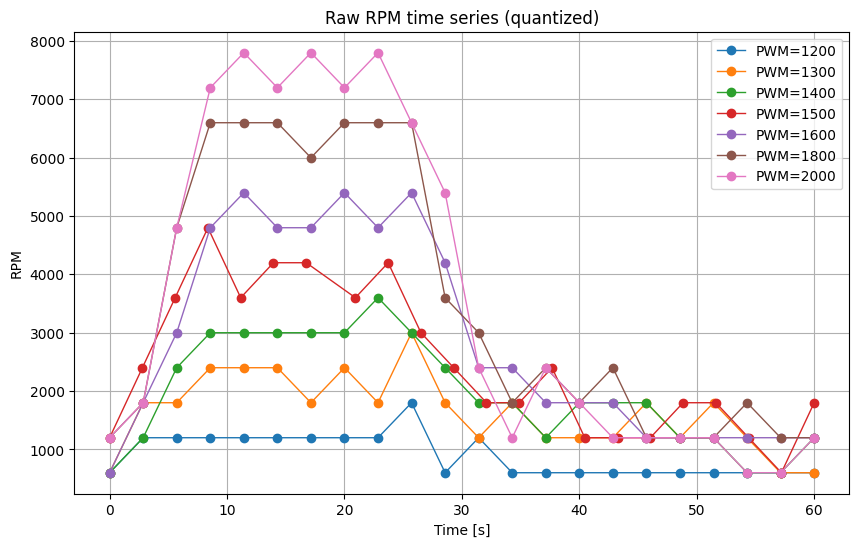

In [271]:
plt.figure(figsize=(10, 6))
for pwm, g in df_scaled.groupby("pwm"):
    plt.plot(g["time"], g["rpm"], marker="o", linewidth=1, label=f"PWM={pwm}")
plt.xlabel("Time [s]")
plt.ylabel("RPM")
plt.title("Raw RPM time series (quantized)")
plt.legend()
plt.grid(True)
plt.show()


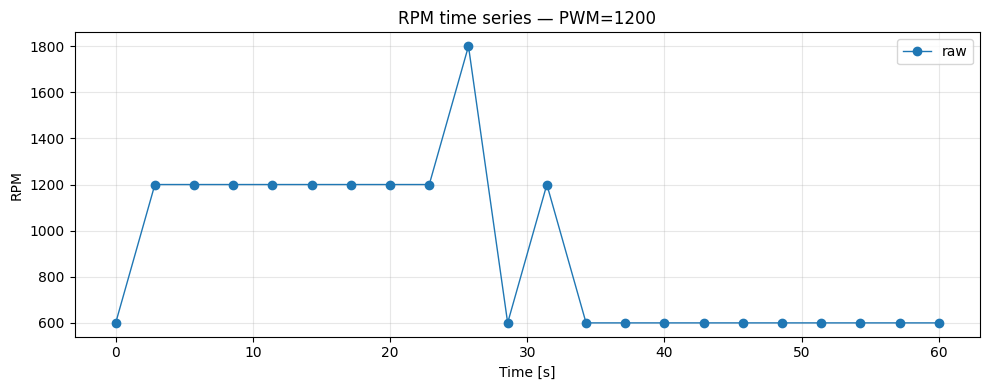

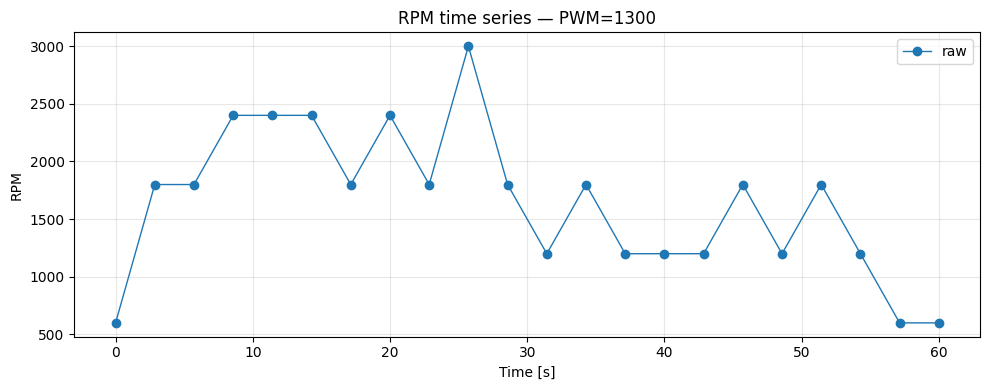

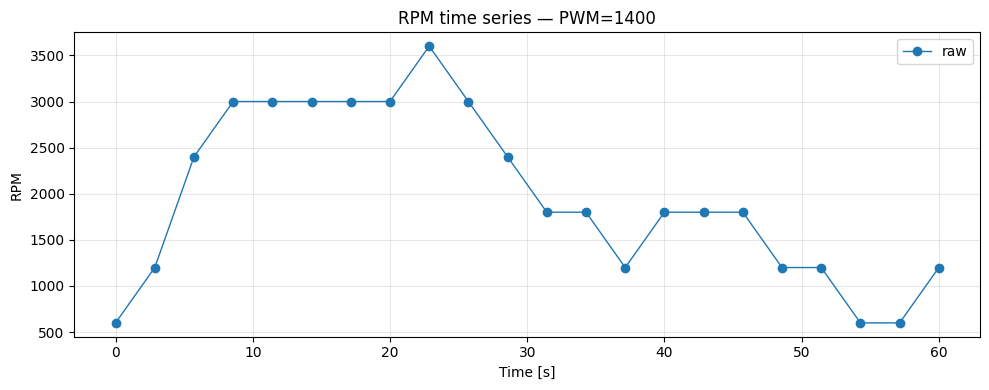

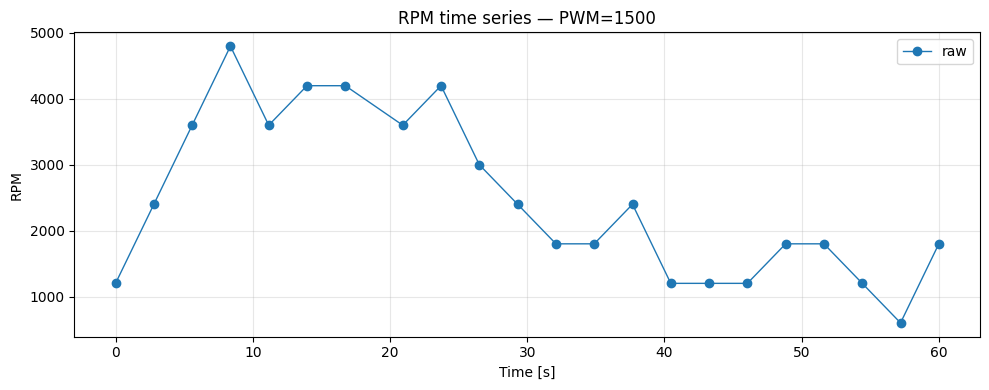

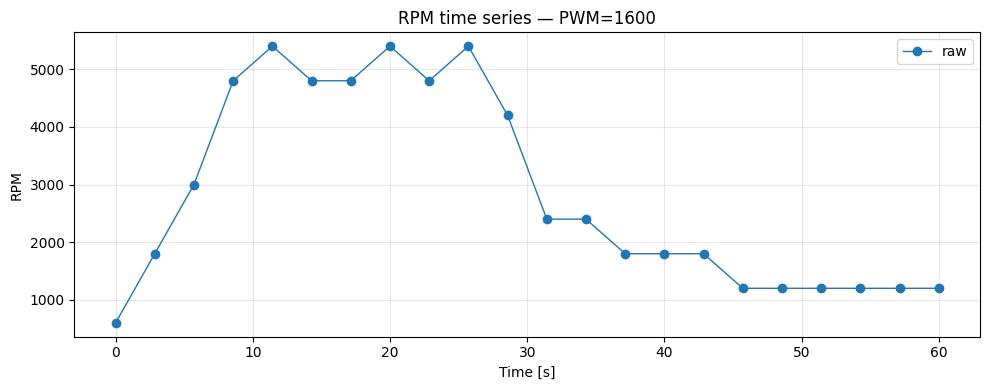

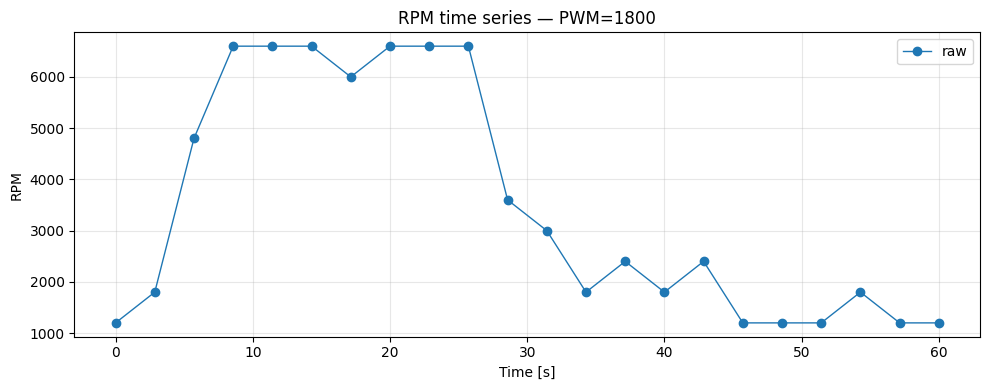

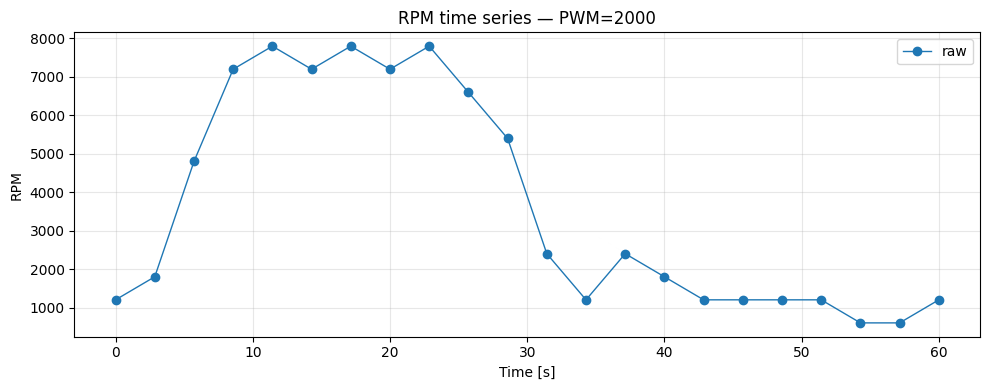

In [272]:
import matplotlib.pyplot as plt

# Sort PWMs for consistent order
pwms = sorted(df_scaled["pwm"].unique())

for pwm in pwms:
    g = df_scaled[df_scaled["pwm"] == pwm].sort_values("time")

    plt.figure(figsize=(10, 4))
    plt.plot(g["time"], g["rpm"], marker="o", linewidth=1, label="raw")

    plt.xlabel("Time [s]")
    plt.ylabel("RPM")
    plt.title(f"RPM time series — PWM={pwm}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


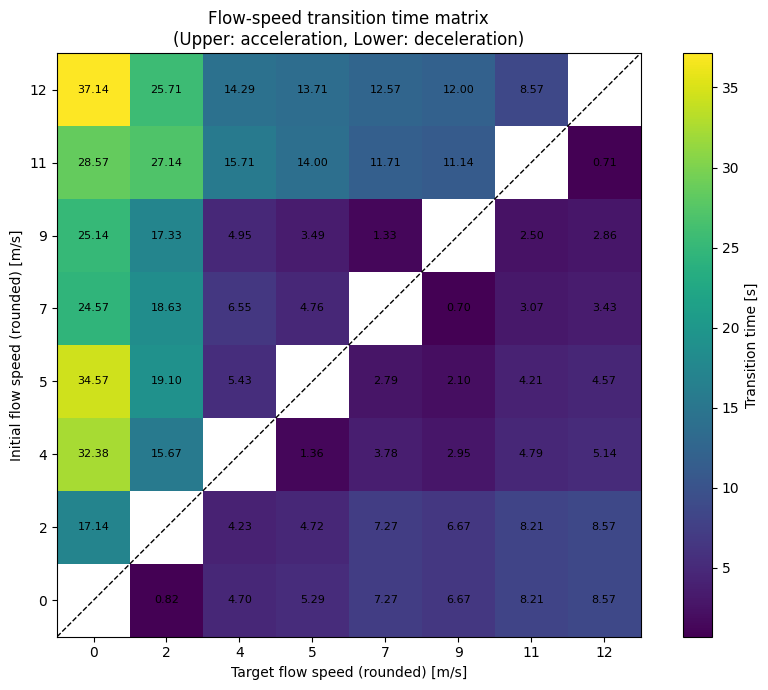

,0,2,4,5,7,9,11,12
0,NaN,0.816327,4.703212,5.294352,7.266542,6.666667,8.214286,8.571429
2,17.142857,NaN,4.227021,4.722924,7.266542,6.666667,8.214286,8.571429
4,32.380952,15.669989,NaN,1.364784,3.783153,2.952381,4.785714,5.142857
5,34.571429,19.095460,5.434330,NaN,2.791459,2.095238,4.214286,4.571429
7,24.571267,18.627759,6.551347,4.758434,NaN,0.698611,3.071590,3.428733
9,25.142857,17.333333,4.952381,3.492063,1.333531,NaN,2.500000,2.857143
11,28.571429,27.142857,15.714286,14.000000,11.714448,11.142857,NaN,0.714286
12,37.142857,25.714286,14.285714,13.714286,12.571590,12.000000,8.571429,NaN


In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Inputs: rpm_data + flow table
# ----------------------------
rpm_data = rpm_data  # you already have it

flow_table = pd.DataFrame({
    "pwm": [2000, 1800, 1600, 1500, 1400, 1300, 1200],
    "v_avg": [12.4, 11.1, 8.8, 6.8, 5.2, 3.7, 2.3],
})
pwm_to_v = dict(zip(flow_table["pwm"], flow_table["v_avg"]))

PWMS = sorted(rpm_data.keys())
T_TOTAL = 60.0  # scale each record to 60 s

# ----------------------------
# Build df and scale time per PWM to 60s
# ----------------------------
rows = []
scale = {}
for pwm in PWMS:
    arr = rpm_data[pwm]
    t = np.array([r["time"] for r in arr], float)
    y = np.array([r["rpm"] for r in arr], float)

    t0 = t.min()
    t1 = t.max()
    s = T_TOTAL / (t1 - t0) if (t1 - t0) > 0 else 1.0
    scale[pwm] = s
    ts = (t - t0) * s

    for ti, yi in zip(ts, y):
        rows.append({"pwm": pwm, "time_s": float(ti), "rpm": float(yi)})

df = pd.DataFrame(rows).sort_values(["pwm", "time_s"]).reset_index(drop=True)

# ----------------------------
# Simple median filter (small window)
# ----------------------------
def median_filter(y, k=3):
    y = np.asarray(y, float)
    if k <= 1:
        return y.copy()
    kk = k//2
    out = y.copy()
    for i in range(len(y)):
        a = max(0, i-kk)
        b = min(len(y), i+kk+1)
        out[i] = np.median(y[a:b])
    return out

# add filtered column
df["rpm_f"] = np.nan
for pwm in PWMS:
    idx = df["pwm"] == pwm
    y = df.loc[idx, "rpm"].to_numpy(float)
    df.loc[idx, "rpm_f"] = median_filter(y, k=3)

# ----------------------------
# Plateau rpm estimate per PWM (robust): median of top quantile
# (works with quantized signals better than fancy fits)
# ----------------------------
def estimate_plateau_rpm(y, top_frac=0.25):
    y = np.asarray(y, float)
    if len(y) == 0:
        return np.nan
    y_sorted = np.sort(y)
    n = len(y_sorted)
    k = max(1, int(np.ceil(top_frac * n)))
    return float(np.median(y_sorted[-k:]))

plateau_rpm = {}
for pwm in PWMS:
    y = df[df["pwm"] == pwm]["rpm_f"].to_numpy(float)
    plateau_rpm[pwm] = estimate_plateau_rpm(y, top_frac=0.25)

# Define "rest RPM" as the minimum observed filtered RPM across all runs
RPM_REST = float(df["rpm_f"].min())

# ----------------------------
# Crossing time (linear interp) within a time window and direction
# ----------------------------
def first_crossing_time(t, y, level, direction="up", t_start=None, t_end=None):
    t = np.asarray(t, float)
    y = np.asarray(y, float)

    if t_start is None: t_start = t.min()
    if t_end   is None: t_end   = t.max()

    mask = (t >= t_start) & (t <= t_end)
    t2, y2 = t[mask], y[mask]
    if len(t2) < 2:
        return np.nan

    if direction == "up":
        cond = y2 >= level
    else:
        cond = y2 <= level

    idxs = np.where(cond)[0]
    if len(idxs) == 0:
        return np.nan
    j = int(idxs[0])
    if j == 0:
        return float(t2[0])

    t1, tB = float(t2[j-1]), float(t2[j])
    y1, yB = float(y2[j-1]), float(y2[j])
    if yB == y1:
        return float(tB)
    a = (level - y1) / (yB - y1)
    return float(t1 + a * (tB - t1))

# ----------------------------
# For each run: define rise window [t0, t_peak] and decay window [t_peak, t_end]
# (no assumptions about "cmd end" — use actual peak)
# ----------------------------
def rise_decay_windows(t, y):
    i_peak = int(np.nanargmax(y))
    return (float(t[0]), float(t[i_peak])), (float(t[i_peak]), float(t[-1]))

# ----------------------------
# Transition time A->B using ENSEMBLE of runs that pass both levels
# Use filtered RPM. Levels are RPM plateaus (or rest RPM for v=0).
# ----------------------------
def transition_time_ensemble(pwm_A, pwm_B, mode="acc"):
    """
    mode='acc' : A -> B where B>A in speed (use rising segments)
    mode='dec' : A -> B where B<A in speed (use decaying segments)
    """
    # define rpm levels
    rpm_A = RPM_REST if pwm_A is None else plateau_rpm[pwm_A]
    rpm_B = RPM_REST if pwm_B is None else plateau_rpm[pwm_B]

    if not np.isfinite(rpm_A) or not np.isfinite(rpm_B):
        return np.nan, 0, []

    # choose runs that reach at least max(rpm_A, rpm_B)
    need = max(rpm_A, rpm_B)
    candidate_runs = []
    for pwm_run in PWMS:
        if plateau_rpm[pwm_run] >= need - 1e-9:
            candidate_runs.append(pwm_run)

    dts = []
    details = []

    for pwm_run in candidate_runs:
        g = df[df["pwm"] == pwm_run].sort_values("time_s")
        t = g["time_s"].to_numpy(float)
        y = g["rpm_f"].to_numpy(float)

        (t0, t_peak), (t_peak2, t_end) = rise_decay_windows(t, y)

        if mode == "acc":
            # ensure A < B in rpm sense
            if rpm_B <= rpm_A:
                continue
            tA = first_crossing_time(t, y, rpm_A, direction="up", t_start=t0, t_end=t_peak)
            tB = first_crossing_time(t, y, rpm_B, direction="up", t_start=t0, t_end=t_peak)
        else:
            # dec: rpm_B < rpm_A (A is initial, B is target lower)
            if rpm_B >= rpm_A:
                continue
            # in decay, we cross down through rpm_A then rpm_B later
            tA = first_crossing_time(t, y, rpm_A, direction="down", t_start=t_peak2, t_end=t_end)
            tB = first_crossing_time(t, y, rpm_B, direction="down", t_start=t_peak2, t_end=t_end)

        if np.isfinite(tA) and np.isfinite(tB) and tB >= tA:
            dt = float(tB - tA)
            dts.append(dt)
            details.append({"run_pwm": pwm_run, "dt_s": dt})

    if len(dts) == 0:
        return np.nan, 0, details

    return float(np.mean(dts)), len(dts), details

# ----------------------------
# Build velocity grid (rounded to integer m/s) + include v=0
# ----------------------------
v_levels = [0] + sorted([int(round(pwm_to_v[p])) for p in PWMS])
# map rounded v -> pwm (if duplicates, keep the highest pwm; you can change this)
v_to_pwm = {int(round(pwm_to_v[p])): p for p in PWMS}
v_to_pwm[0] = None  # None means "rest"

# matrix: rows=initial v, cols=target v
M = pd.DataFrame(index=v_levels, columns=v_levels, dtype=float)

for v_i in v_levels:
    for v_j in v_levels:
        if v_i == v_j:
            M.loc[v_i, v_j] = np.nan
            continue

        pwm_i = v_to_pwm[v_i]
        pwm_j = v_to_pwm[v_j]

        if v_j > v_i:
            # acceleration: upper triangle
            mean_dt, n, _ = transition_time_ensemble(pwm_i, pwm_j, mode="acc")
        else:
            # deceleration: lower triangle
            mean_dt, n, _ = transition_time_ensemble(pwm_i, pwm_j, mode="dec")

        M.loc[v_i, v_j] = mean_dt

# ----------------------------
# Plot heatmap with annotations
# ----------------------------
A = M.to_numpy(float)

plt.figure(figsize=(9, 7))
im = plt.imshow(A, origin="lower")
plt.colorbar(im, label="Transition time [s]")

plt.xticks(range(len(v_levels)), v_levels)
plt.yticks(range(len(v_levels)), v_levels)
plt.xlabel("Target flow speed (rounded) [m/s]")
plt.ylabel("Initial flow speed (rounded) [m/s]")
plt.title("Flow-speed transition time matrix\n(Upper: acceleration, Lower: deceleration)")

# annotate numbers
for i in range(len(v_levels)):
    for j in range(len(v_levels)):
        val = A[i, j]
        if np.isfinite(val):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

# diagonal
plt.plot([-0.5, len(v_levels)-0.5], [-0.5, len(v_levels)-0.5], "k--", linewidth=1)
plt.tight_layout()
plt.show()

M


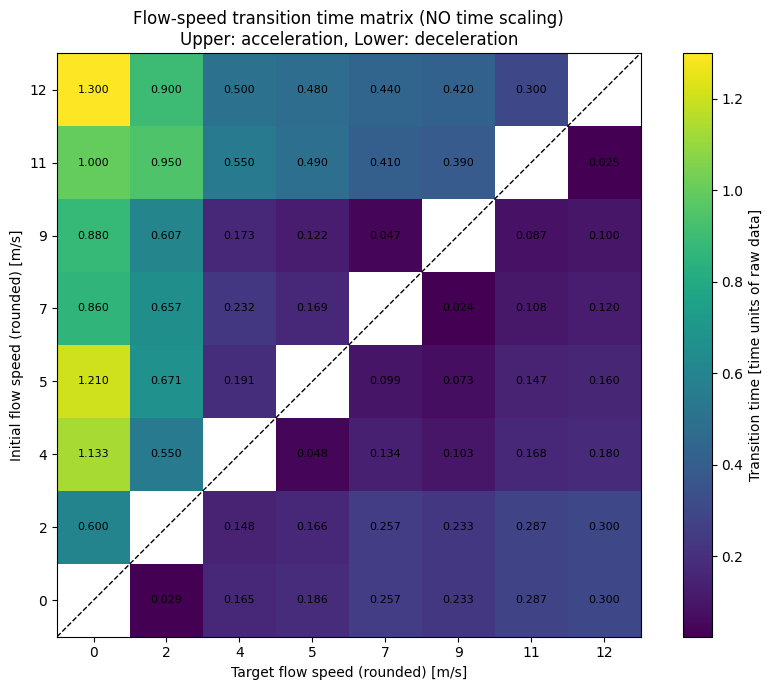

,0,2,4,5,7,9,11,12
0,NaN,0.028571,0.165000,0.186000,0.256654,0.233333,0.287500,0.300000
2,0.600000,NaN,0.148333,0.166000,0.256654,0.233333,0.287500,0.300000
4,1.133333,0.550000,NaN,0.048000,0.134154,0.103333,0.167500,0.180000
5,1.210000,0.670667,0.190667,NaN,0.099154,0.073333,0.147500,0.160000
7,0.859994,0.657495,0.232495,0.169161,NaN,0.024451,0.107506,0.120006
9,0.880000,0.606667,0.173333,0.122222,0.046674,NaN,0.087500,0.100000
11,1.000000,0.950000,0.550000,0.490000,0.410006,0.390000,NaN,0.025000
12,1.300000,0.900000,0.500000,0.480000,0.440006,0.420000,0.300000,NaN


In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Inputs: rpm_data + flow table
# ----------------------------
rpm_data = rpm_data  # you already have it

flow_table = pd.DataFrame({
    "pwm": [2000, 1800, 1600, 1500, 1400, 1300, 1200],
    "v_avg": [12.4, 11.1, 8.8, 6.8, 5.2, 3.7, 2.3],
})
pwm_to_v = dict(zip(flow_table["pwm"], flow_table["v_avg"]))

PWMS = sorted(rpm_data.keys())

# ----------------------------
# Build df (NO time scaling)
# ----------------------------
rows = []
for pwm in PWMS:
    for r in rpm_data[pwm]:
        rows.append({
            "pwm": pwm,
            "time_s": float(r["time"]),   # keep as-is
            "rpm": float(r["rpm"])
        })

df = pd.DataFrame(rows).sort_values(["pwm", "time_s"]).reset_index(drop=True)

# ----------------------------
# Simple median filter (small window)
# ----------------------------
def median_filter(y, k=3):
    y = np.asarray(y, float)
    if k <= 1:
        return y.copy()
    kk = k // 2
    out = y.copy()
    for i in range(len(y)):
        a = max(0, i - kk)
        b = min(len(y), i + kk + 1)
        out[i] = np.median(y[a:b])
    return out

df["rpm_f"] = np.nan
for pwm in PWMS:
    idx = df["pwm"] == pwm
    y = df.loc[idx, "rpm"].to_numpy(float)
    df.loc[idx, "rpm_f"] = median_filter(y, k=3)

# ----------------------------
# Plateau estimate per PWM: median of top fraction
# ----------------------------
def estimate_plateau_rpm(y, top_frac=0.25):
    y = np.asarray(y, float)
    if len(y) == 0:
        return np.nan
    ys = np.sort(y)
    n = len(ys)
    k = max(1, int(np.ceil(top_frac * n)))
    return float(np.median(ys[-k:]))

plateau_rpm = {}
for pwm in PWMS:
    y = df[df["pwm"] == pwm]["rpm_f"].to_numpy(float)
    plateau_rpm[pwm] = estimate_plateau_rpm(y, top_frac=0.25)

# Define "rest RPM" as minimum observed filtered RPM across all runs
RPM_REST = float(df["rpm_f"].min())

# ----------------------------
# Crossing time (linear interp) within a window
# ----------------------------
def first_crossing_time(t, y, level, direction="up", t_start=None, t_end=None):
    t = np.asarray(t, float)
    y = np.asarray(y, float)

    if t_start is None: t_start = float(t.min())
    if t_end   is None: t_end   = float(t.max())

    mask = (t >= t_start) & (t <= t_end)
    t2, y2 = t[mask], y[mask]
    if len(t2) < 2:
        return np.nan

    cond = (y2 >= level) if direction == "up" else (y2 <= level)
    idxs = np.where(cond)[0]
    if len(idxs) == 0:
        return np.nan

    j = int(idxs[0])
    if j == 0:
        return float(t2[0])

    t1, tB = float(t2[j-1]), float(t2[j])
    y1, yB = float(y2[j-1]), float(y2[j])
    if yB == y1:
        return float(tB)

    a = (level - y1) / (yB - y1)
    return float(t1 + a * (tB - t1))

# ----------------------------
# Rise/decay windows from peak (no cmd-end assumptions)
# ----------------------------
def rise_decay_windows(t, y):
    i_peak = int(np.nanargmax(y))
    return (float(t[0]), float(t[i_peak])), (float(t[i_peak]), float(t[-1]))

# ----------------------------
# Ensemble transition time A->B using runs that reach both levels
# pwm=None means rest state (RPM_REST)
# ----------------------------
def transition_time_ensemble(pwm_A, pwm_B, mode="acc"):
    rpm_A = RPM_REST if pwm_A is None else plateau_rpm[pwm_A]
    rpm_B = RPM_REST if pwm_B is None else plateau_rpm[pwm_B]

    if not np.isfinite(rpm_A) or not np.isfinite(rpm_B):
        return np.nan, 0, []

    need = max(rpm_A, rpm_B)

    candidate_runs = [p for p in PWMS if plateau_rpm[p] >= need - 1e-9]

    dts = []
    details = []

    for pwm_run in candidate_runs:
        g = df[df["pwm"] == pwm_run].sort_values("time_s")
        t = g["time_s"].to_numpy(float)
        y = g["rpm_f"].to_numpy(float)

        (t0, t_peak), (t_peak2, t_end) = rise_decay_windows(t, y)

        if mode == "acc":
            if rpm_B <= rpm_A:
                continue
            tA = first_crossing_time(t, y, rpm_A, direction="up",   t_start=t0,      t_end=t_peak)
            tB = first_crossing_time(t, y, rpm_B, direction="up",   t_start=t0,      t_end=t_peak)
        else:
            if rpm_B >= rpm_A:
                continue
            tA = first_crossing_time(t, y, rpm_A, direction="down", t_start=t_peak2, t_end=t_end)
            tB = first_crossing_time(t, y, rpm_B, direction="down", t_start=t_peak2, t_end=t_end)

        if np.isfinite(tA) and np.isfinite(tB) and tB >= tA:
            dt = float(tB - tA)
            dts.append(dt)
            details.append({"run_pwm": pwm_run, "dt_s": dt})

    if len(dts) == 0:
        return np.nan, 0, details

    return float(np.mean(dts)), len(dts), details

# ----------------------------
# Velocity grid (rounded) + include v=0
# ----------------------------
v_levels = [0] + sorted([int(round(pwm_to_v[p])) for p in PWMS])

# map rounded v -> pwm (if collisions, this keeps last; adjust if needed)
v_to_pwm = {int(round(pwm_to_v[p])): p for p in PWMS}
v_to_pwm[0] = None  # rest

M = pd.DataFrame(index=v_levels, columns=v_levels, dtype=float)

for v_i in v_levels:
    for v_j in v_levels:
        if v_i == v_j:
            M.loc[v_i, v_j] = np.nan
            continue

        pwm_i = v_to_pwm[v_i]
        pwm_j = v_to_pwm[v_j]

        if v_j > v_i:
            mean_dt, n, _ = transition_time_ensemble(pwm_i, pwm_j, mode="acc")
        else:
            mean_dt, n, _ = transition_time_ensemble(pwm_i, pwm_j, mode="dec")

        M.loc[v_i, v_j] = mean_dt

# ----------------------------
# Plot heatmap + numbers
# ----------------------------
A = M.to_numpy(float)

plt.figure(figsize=(9, 7))
im = plt.imshow(A, origin="lower")
plt.colorbar(im, label="Transition time [time units of raw data]")

plt.xticks(range(len(v_levels)), v_levels)
plt.yticks(range(len(v_levels)), v_levels)
plt.xlabel("Target flow speed (rounded) [m/s]")
plt.ylabel("Initial flow speed (rounded) [m/s]")
plt.title("Flow-speed transition time matrix (NO time scaling)\nUpper: acceleration, Lower: deceleration")

for i in range(len(v_levels)):
    for j in range(len(v_levels)):
        val = A[i, j]
        if np.isfinite(val):
            plt.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8)

plt.plot([-0.5, len(v_levels)-0.5], [-0.5, len(v_levels)-0.5], "k--", linewidth=1)
plt.tight_layout()
plt.show()

M


In [286]:
import pandas as pd
import numpy as np

# Tabla de velocidades (la que ya usas)
flow_table = pd.DataFrame({
    "pwm": [2000, 1800, 1600, 1500, 1400, 1300, 1200],
    "v_min": [12.0, 10.5, 8.1, 6.3, 4.8, 3.5, 2.1],
    "v_max": [13.4, 12.0, 9.4, 7.3, 5.5, 3.9, 2.4],
    "v_avg": [12.4, 11.1, 8.8, 6.8, 5.2, 3.7, 2.3],
})

# ---- estimar RPM de plateau (robusto) ----
def estimate_plateau_rpm(rpm_values, top_frac=0.25):
    y = np.asarray(rpm_values, float)
    y = np.sort(y)
    k = max(1, int(np.ceil(top_frac * len(y))))
    return float(np.median(y[-k:]))

rows = []

for pwm in sorted(rpm_data.keys()):
    rpm_vals = [r["rpm"] for r in rpm_data[pwm]]
    rpm_plateau = estimate_plateau_rpm(rpm_vals)

    rows.append({
        "PWM": pwm,
        "RPM_plateau": rpm_plateau,
    })

rpm_table = pd.DataFrame(rows)

# ---- merge con velocidades ----
summary_table = rpm_table.merge(flow_table, left_on="PWM", right_on="pwm", how="left")
summary_table = summary_table.drop(columns=["pwm"])

# ordenar de menor a mayor velocidad
summary_table = summary_table.sort_values("v_avg").reset_index(drop=True)

summary_table


,PWM,RPM_plateau,v_min,v_max,v_avg
0,1200,1200.000,2.1,2.4,2.3
1,1300,2400.000,3.5,3.9,3.7
2,1400,3000.000,4.8,5.5,5.2
3,1500,4199.915,6.3,7.3,6.8
4,1600,5100.000,8.1,9.4,8.8
5,1800,6600.000,10.5,12.0,11.1
6,2000,7500.000,12.0,13.4,12.4
